In [54]:
import os,sys,time
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from shutil import copy as cp
from glob import glob
import RealSim_IFS

## Examine some TNG100-1 maps

The gas maps look very strange. Also a problem with camera angles. Different camera angles show the same objects from the same orientation.

/localscratch/bottrell.34986568.0
/home/bottrell/scratch/Merger_Kinematics/LOSVD/TNG100-1/099/kinemetry_datacube_TNG100-1_99_528190_stars_i1.fits
8.034223079681396
/home/bottrell/scratch/Merger_Kinematics/LOSVD/TNG100-1/099/kinemetry_datacube_TNG100-1_99_404216_gas_i0.fits
8.109387874603271
/home/bottrell/scratch/Merger_Kinematics/LOSVD/TNG100-1/099/kinemetry_datacube_TNG100-1_99_403910_stars_i2.fits
7.868885278701782
/home/bottrell/scratch/Merger_Kinematics/LOSVD/TNG100-1/099/kinemetry_datacube_TNG100-1_99_427314_gas_i1.fits
7.848468065261841


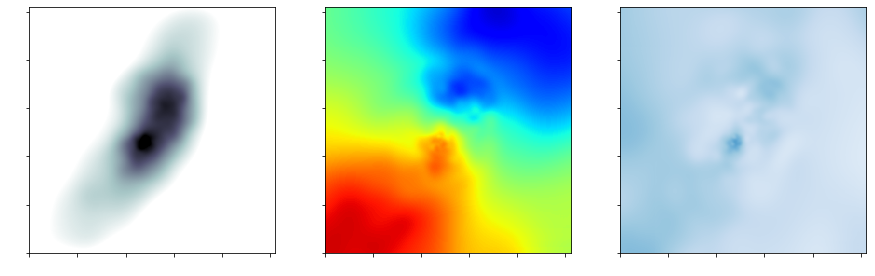

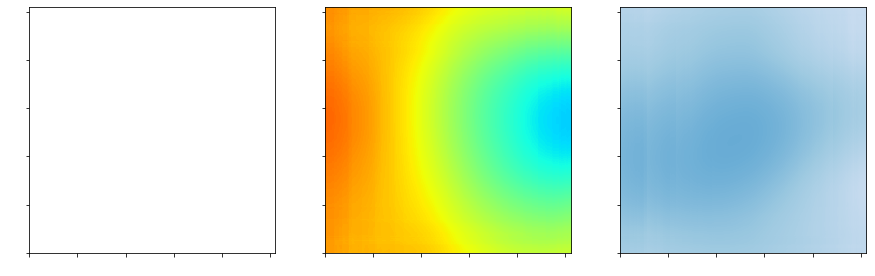

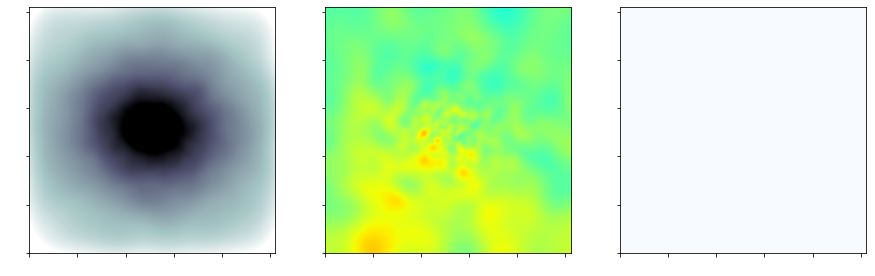

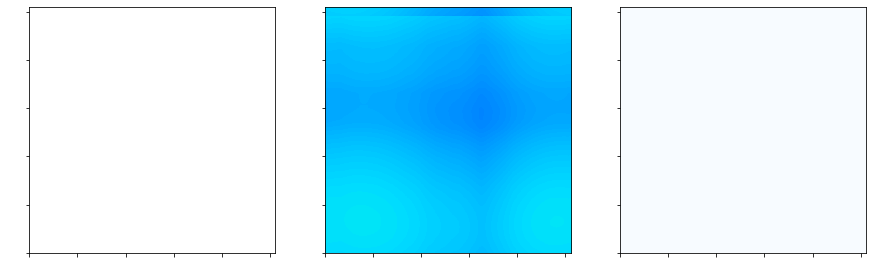

In [55]:
def generate_maps(losvd_name):
    if not os.access(losvd_name,0):
        print('LOSVD file not found')
    else:
        losvd_head = fits.getheader(losvd_name)
        losvd_data = fits.getdata(losvd_name)
        losvd_shape = losvd_data.shape
        vlim = losvd_head['VLIM'] # km/s
        delv = losvd_head['DELV'] # km/s
        fov = losvd_head['FOVSIZE']/1000. # kpc
        vel = np.linspace(-vlim,vlim,losvd_shape[-1],endpoint=False)+delv/2.
        sum_wi = np.nansum(losvd_data,axis=-1)
        sum_wivi = np.nansum(losvd_data*vel,axis=-1)
        vbar = sum_wivi/sum_wi
        Nprime = np.nansum(losvd_data>0,axis=-1)
        vstd = np.nansum(losvd_data*(vel-vbar[...,np.newaxis])**2,axis=-1)
        vstd /= (Nprime-1)/Nprime*sum_wi
        vstd = np.sqrt(vstd)
        losvd_maps = np.array([sum_wi,vbar,vstd])
        return losvd_maps
    
def main():
    
    if 'SLURM_TMPDIR' in [key for key in os.environ.keys()]:
        wdir = os.environ['SLURM_TMPDIR']
        os.chdir(wdir)
        print(os.getcwd())
        
    losvd_dir = '/home/bottrell/scratch/Merger_Kinematics/LOSVD/TNG100-1/099'
    filenames = glob('{}/*.fits'.format(losvd_dir))
    
    
    for filename in filenames[:4]:
        print(filename)
        start = time.time()
        localfile = filename.replace(losvd_dir,wdir)
        start = time.time()
        cp(filename,localfile)
        maps = RealSim_IFS.Generate_Maps_From_File(localfile)
        print(time.time()-start)
        if os.access(localfile,0):os.remove(localfile)
            
        fig,axarr = plt.subplots(1,3,figsize=(15,5))
        ax = axarr[0]
        ax.imshow(np.log10(maps[0]),vmin=4.5,vmax=6,cmap='bone_r',origin='lower')
        ax = axarr[1]
        ax.imshow(maps[1],vmin=-100,vmax=100,cmap='jet_r',origin='lower')
        ax = axarr[2]
        ax.imshow(maps[2],vmin=0,vmax=100,cmap='Blues_r',origin='lower')

#         fig,axarr = plt.subplots(1,3,figsize=(15,5))
#         ax = axarr[0]
#         losvd_head = fits.getheader(filename)
#         losvd_data = fits.getdata(filename)
#         ax.imshow(np.sum(losvd_data,axis=2),cmap='bone_r',origin='lower')
#         print(losvd_data.shape)
#         losvd_shape = losvd_data.shape
#         vlim = losvd_head['VLIM'] # km/s
#         delv = losvd_head['DELV'] # km/s
#         fov = losvd_head['FOVSIZE']/1000. # kpc
#         vel = np.linspace(-vlim,vlim,losvd_shape[-1],endpoint=False)+delv/2.
        
#         fig,ax=plt.subplots(1,1,figsize=(5,5))
#         v = np.linspace(-700,700,300,endpoint=False)+4.6666666666667/2
#         for i in range(512):
#             ax.plot(v,losvd_data[256,i,:])
        
        
    
if __name__ == '__main__':
    main()

## Examine individual cube more closely

Reshape cube to channels first (`Nels`,`spatial_x`,`spatial_y`).

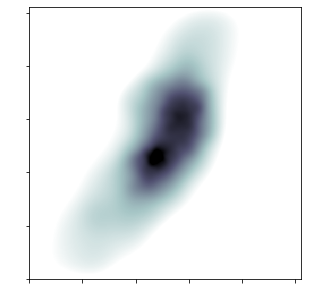

In [52]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import time

losvd_dir = '/home/bottrell/scratch/Merger_Kinematics/LOSVD/TNG100-1/099'
filename = '{}/kinemetry_datacube_TNG100-1_99_528190_stars_i1.fits'.format(losvd_dir)

data = fits.getdata(filename)
hdr = fits.getheader(filename)
data = data.transpose(2,0,1)

fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(np.log10(np.sum(data,axis=0)),vmin=4.5,vmax=6,origin='lower',cmap='bone_r')

## Generate fiber array

Plot fiber array overtop of data. The diameters of the fiber are entirely contrived. The fiber positons/diamters are scaled such that they cover the full FOV of the idealized cube. In a real scenario, we would have some scale for converting spatial pixels in the cube to arcsec. This scale can be applied to the fiber positions and diameters.

(0, 512)

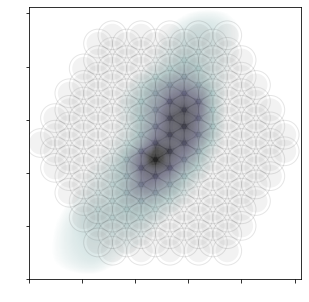

In [48]:
import RealSim_IFS
from matplotlib.patches import Circle
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

# generate array of fiber positions
(xc_arr,yc_arr),params = RealSim_IFS.MaNGA_Observe(bundle_name='None',
                                           fibers_per_side=5,
                                           n_observations='Classic',
                                           bundle_xoffset_arcsec=0.,
                                           bundle_yoffset_arcsec=0.,
                                           rotation_degrees = 0.,
                                           return_params=True)

fiber_diameter_arcsec = params['fiber_diameter_arcsec']
core_diameter_arcsec = params['core_diameter_arcsec']
n_observations = xc_arr.shape[-1]

data_shape = data.shape

size_pixels = 2*(np.max(np.abs(xc_arr))+core_diameter_arcsec/2.)
arcsec_per_pixel = size_pixels/float(data_shape[1])

# rescale and set new origin
xc_cores_pixels = xc_arr.flatten()/arcsec_per_pixel+data_shape[1]/2.
yc_cores_pixels = yc_arr.flatten()/arcsec_per_pixel+data_shape[1]/2.
diam_cores_pixels = core_diameter_arcsec/arcsec_per_pixel
diam_fibers_pixels = fiber_diameter_arcsec/arcsec_per_pixel

fig,ax = plt.subplots(figsize=(5,5))

ax.imshow(np.log10(np.sum(data,axis=0)),vmin=4.5,vmax=6,origin='lower',cmap='bone_r')

for xy in zip(xc_cores_pixels,yc_cores_pixels):
    clad = Circle(xy=xy,radius=diam_fibers_pixels/2,transform=ax.transData,edgecolor='black',facecolor='White',alpha=0.1)
    ax.add_artist(clad)
    core = Circle(xy=xy,radius=diam_cores_pixels/2,transform=ax.transData,edgecolor='None',facecolor='Grey',alpha=0.1)
    ax.add_artist(core)
    
ax.set_xlim(0,data_shape[2])
ax.set_ylim(0,data_shape[1])

## Apply fibers to cube and obtain fiber arrays

Issue encountered here. The process is very memory intensive with large numbers of fibers. Calculations are scaling as  `N_fibers` x `spatial_x` x `spatial_y` x `Nels` x 64 b / 8 b/B. For the 512x512x300 cubes, this is 629MB per fiber placed. This is unfeasible and requires a loop to process rather than broadcasting. I have edited the `Fiber_Observe` function so that it uses a loop over `N_fibers`. It is slower than broadcasting but far less memory intensive. Still, a reasonable amount of time for the process.



In [3]:
start = time.time()
core_arrays,weights = RealSim_IFS.Fiber_Observe(data,xc_cores_pixels,yc_cores_pixels,
                                                diam_cores_pixels,return_weights=True)
print(time.time()-start)

75.6138916015625


Now change map the intensities to the output grid using the `Change_Coords` and `Fiber_to_Grid` functions. Also, make all elements with a value of zero into nans. These will mostly be the pixels outside the observing pattern.

In [39]:
output_grid_dims = (50,50)

core_x_pixels,core_y_pixels,core_diameter_pixels = RealSim_IFS.Change_Coords(xc_cores_pixels,yc_cores_pixels,diam_cores_pixels,
                                                                 input_grid_dims=(data_shape[2],data_shape[1]),
                                                                 output_grid_dims=output_grid_dims)

out_cube,weight_map = RealSim_IFS.Fiber_to_Grid(core_arrays,core_x_pixels,core_y_pixels,core_diameter_pixels,
                    grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=True,
                    gaussian_sigma_pixels=2.,rlim_pixels=3.)

out_cube[out_cube==0.] = np.nan

/scratch/bottrell/Merger_Kinematics/Venv/p37/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


268917552.548676
283737968.4203999


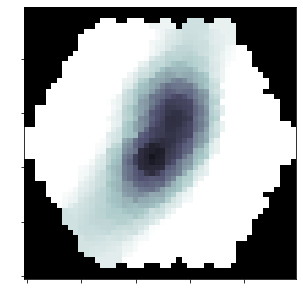

In [47]:
import copy
from matplotlib import cm
cmap = copy.copy(cm.bone_r)
cmap.set_bad('black')

fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(np.log10(np.nansum(out_cube,axis=0)*(50/512)**2),vmin=4.5,vmax=6,origin='lower',cmap=cmap)
print(np.nansum(out_cube[150]))
print(np.nansum(data[150]))

/scratch/bottrell/Merger_Kinematics/Venv/p37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


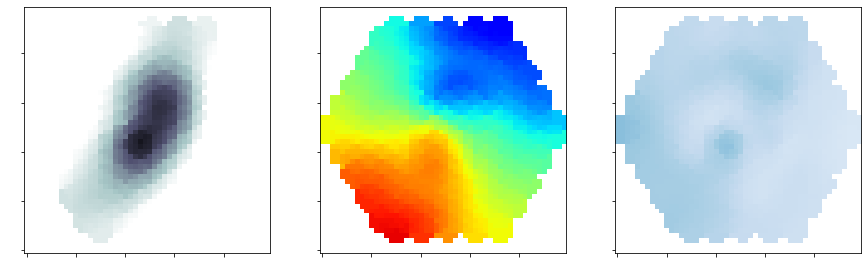

In [46]:
maps = RealSim_IFS.Generate_Maps_From_Data(filename,out_cube)
fig,axarr = plt.subplots(1,3,figsize=(15,5))
ax = axarr[0]
ax.imshow(np.log10(maps[0]*(50/512)**2),vmin=4.5,vmax=6,cmap='bone_r',origin='lower')
ax = axarr[1]
ax.imshow(maps[1],vmin=-100,vmax=100,cmap='jet_r',origin='lower')
ax = axarr[2]
ax.imshow(maps[2],vmin=0,vmax=100,cmap='Blues_r',origin='lower')

In [44]:
print(np.nansum(maps[0]))
print(np.nansum(data))

12316233478.731728
13473614379.32026
